In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available() 
if use_cuda : 
    print("cuda")
else :
    print("cpu")

cuda


In [7]:

data_dir = './data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir  = data_dir + '/test'

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
                    
}
train_data= datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_data= datasets.ImageFolder(test_dir, transform=data_transforms['test'])
valid_data= datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])

dataloaders={ 'train' : torch.utils.data.DataLoader(train_data, batch_size=2,num_workers=0, shuffle=True),
              'valid' : torch.utils.data.DataLoader(valid_data,batch_size=2, num_workers=0,shuffle=False),
              'test'  : torch.utils.data.DataLoader(test_data,batch_size=2,num_workers=0,shuffle=False)
    
}

In [8]:
loaders_transfer = dataloaders.copy()

In [4]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048,3)
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

use_cuda = torch.cuda.is_available()

print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/darth/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0000001)

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx,(data,target) in enumerate(dataloaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx%50==0:
                 print('Epoch: {} \tTraining Loss: {:.6f} '.format(epoch,train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data,target) in enumerate(dataloaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min=valid_loss
            print("Saving your model ...............................")
        
        
    return model

In [14]:
#model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.486307 
Epoch: 1 	Training Loss: 0.803655 
Epoch: 1 	Training Loss: 0.841415 
Epoch: 1 	Training Loss: 0.845517 
Epoch: 1 	Training Loss: 0.840153 
Epoch: 1 	Training Loss: 0.838696 
Epoch: 1 	Training Loss: 0.833651 
Epoch: 1 	Training Loss: 0.851497 
Epoch: 1 	Training Loss: 0.851276 
Epoch: 1 	Training Loss: 0.846420 
Epoch: 1 	Training Loss: 0.844079 
Epoch: 1 	Training Loss: 0.839949 
Epoch: 1 	Training Loss: 0.839605 
Epoch: 1 	Training Loss: 0.852153 
Epoch: 1 	Training Loss: 0.865287 
Epoch: 1 	Training Loss: 0.863514 
Epoch: 1 	Training Loss: 0.867638 
Epoch: 1 	Training Loss: 0.865418 
Epoch: 1 	Training Loss: 0.871049 
Epoch: 1 	Training Loss: 0.863384 
Epoch: 1 	Training Loss: 0.866391 	Validation Loss: 0.665272
Saving your model ...............................
Epoch: 2 	Training Loss: 0.400282 
Epoch: 2 	Training Loss: 0.957783 
Epoch: 2 	Training Loss: 0.887360 
Epoch: 2 	Training Loss: 0.856629 
Epoch: 2 	Training Loss: 0.857357 
Epoch: 2 	Trai

Epoch: 11 	Training Loss: 0.858624 
Epoch: 11 	Training Loss: 0.855209 
Epoch: 11 	Training Loss: 0.854060 
Epoch: 11 	Training Loss: 0.860631 
Epoch: 11 	Training Loss: 0.871833 
Epoch: 11 	Training Loss: 0.867136 
Epoch: 11 	Training Loss: 0.870071 
Epoch: 11 	Training Loss: 0.862042 	Validation Loss: 0.633238
Epoch: 12 	Training Loss: 0.951514 
Epoch: 12 	Training Loss: 0.738731 
Epoch: 12 	Training Loss: 0.777658 
Epoch: 12 	Training Loss: 0.780286 
Epoch: 12 	Training Loss: 0.831444 
Epoch: 12 	Training Loss: 0.825636 
Epoch: 12 	Training Loss: 0.857417 
Epoch: 12 	Training Loss: 0.869346 
Epoch: 12 	Training Loss: 0.864180 
Epoch: 12 	Training Loss: 0.854583 
Epoch: 12 	Training Loss: 0.846315 
Epoch: 12 	Training Loss: 0.841011 
Epoch: 12 	Training Loss: 0.843446 
Epoch: 12 	Training Loss: 0.850962 
Epoch: 12 	Training Loss: 0.851953 
Epoch: 12 	Training Loss: 0.859639 
Epoch: 12 	Training Loss: 0.872949 
Epoch: 12 	Training Loss: 0.877649 
Epoch: 12 	Training Loss: 0.887940 
Ep

In [21]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.012556


Test Accuracy: 65% (393/600)


In [23]:
#torch.save(model_transfer.state_dict(), 'model.pth')

In [24]:
model_transfer.load_state_dict(torch.load('final.pth'))

<All keys matched successfully>

In [25]:
from PIL import Image
from torch.autograd import Variable

class_names = [item[:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def skin_detector(img_path):
    image_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    image = image_transform(Image.open(img_path))
    image = image.unsqueeze(0)
    prob_class = False
    
    if use_cuda:
        prob_class = model_transfer.forward(Variable(image.cuda())).cuda()
    else:
        prob_class = model_transfer.forward(Variable(image))
    
    return class_names[prob_class.data.cpu().numpy().argmax()]

In [26]:
from PIL import Image
from torch.autograd import Variable

def predict_cancer(img_path):
    skin = skin_detector(img_path)
    img = plt.imread(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    if (skin):
        print(skin_detector(img_path))

nevus


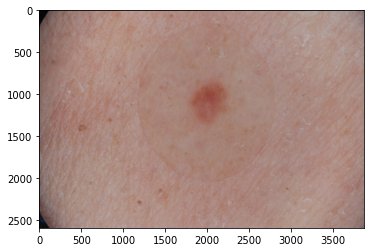

In [27]:
predict_cancer(test_dir + '/nevus/ISIC_0013226.jpg')

melanoma


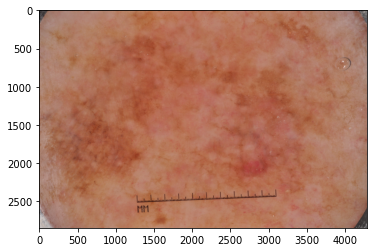

In [28]:
predict_cancer(test_dir + '/melanoma/ISIC_0013833.jpg')

seborrheic keratosis


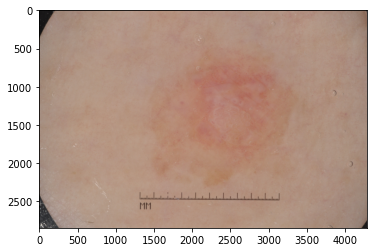

In [29]:
predict_cancer(test_dir + '/seborrheic_keratosis/ISIC_0014500.jpg')